In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
df=pd.read_csv('euro_exchange_rate.csv')
df.head()

,Date,USD,JPY,BGN,CYP,CZK,DKK,EEK,GBP,HUF,...,INR,KRW,MXN,MYR,NZD,PHP,SGD,THB,ZAR,Unnamed: 42
0,2023-04-12,1.0922,146.09,1.9558,NaN,23.421,7.4506,NaN,0.88038,376.23,...,89.6875,1448.10,19.7972,4.8193,1.7649,60.291,1.4538,37.391,20.1330,NaN
1,2023-04-11,1.0905,145.28,1.9558,NaN,23.469,7.4505,NaN,0.87738,375.23,...,89.5205,1441.82,19.7901,4.8184,1.7566,59.996,1.4526,37.361,19.9013,NaN
2,2023-04-06,1.0915,143.49,1.9558,NaN,23.409,7.4510,NaN,0.87495,376.10,...,89.3655,1438.81,19.9624,4.8015,1.7387,59.562,1.4507,37.171,19.8929,NaN
3,2023-04-05,1.0940,143.74,1.9558,NaN,23.429,7.4498,NaN,0.87685,376.19,...,89.7215,1434.80,19.8441,4.8120,1.7349,59.604,1.4512,37.032,19.6107,NaN
4,2023-04-04,1.0901,144.94,1.9558,NaN,23.418,7.4513,NaN,0.87333,376.83,...,89.5900,1434.69,19.6561,4.8030,1.7336,59.436,1.4467,37.314,19.4414,NaN


In [3]:
df=df.drop('Unnamed: 42', axis=1)
df.columns

Index(['Date', 'USD', 'JPY', 'BGN', 'CYP', 'CZK', 'DKK', 'EEK', 'GBP', 'HUF',
       'LTL', 'LVL', 'MTL', 'PLN', 'ROL', 'RON', 'SEK', 'SIT', 'SKK', 'CHF',
       'ISK', 'NOK', 'HRK', 'RUB', 'TRL', 'TRY', 'AUD', 'BRL', 'CAD', 'CNY',
       'HKD', 'IDR', 'ILS', 'INR', 'KRW', 'MXN', 'MYR', 'NZD', 'PHP', 'SGD',
       'THB', 'ZAR'],
      dtype='object')

In [4]:
df.isnull().sum()

Date       0
USD        0
JPY        0
BGN      398
CYP     3914
CZK        0
DKK        0
EEK     3144
GBP        0
HUF        0
LTL     2121
LVL     2376
MTL     3914
PLN        0
ROL     4554
RON     1664
SEK        0
SIT     4169
SKK     3658
CHF        0
ISK     2341
NOK        0
HRK     1670
RUB     1885
TRL     4681
TRY     1537
AUD        0
BRL     2304
CAD        0
CNY     1599
HKD        0
IDR     1599
ILS     3074
INR     2560
KRW        0
MXN     2304
MYR     1599
NZD        0
PHP     1599
SGD        0
THB     1599
ZAR        0
dtype: int64

Print full rows having NULL entries in the df

In [5]:
is_NaN = df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df[row_has_NaN]

In [6]:
print(rows_with_NaN)

            Date     USD     JPY     BGN      CYP     CZK     DKK      EEK  \
0     2023-04-12  1.0922  146.09  1.9558      NaN  23.421  7.4506      NaN   
1     2023-04-11  1.0905  145.28  1.9558      NaN  23.469  7.4505      NaN   
2     2023-04-06  1.0915  143.49  1.9558      NaN  23.409  7.4510      NaN   
3     2023-04-05  1.0940  143.74  1.9558      NaN  23.429  7.4498      NaN   
4     2023-04-04  1.0901  144.94  1.9558      NaN  23.418  7.4513      NaN   
...          ...     ...     ...     ...      ...     ...     ...      ...   
6213  1999-01-08  1.1659  130.09     NaN  0.58187  34.938  7.4433  15.6466   
6214  1999-01-07  1.1632  129.43     NaN  0.58187  34.886  7.4431  15.6466   
6215  1999-01-06  1.1743  131.42     NaN  0.58200  34.850  7.4452  15.6466   
6216  1999-01-05  1.1790  130.96     NaN  0.58230  34.917  7.4495  15.6466   
6217  1999-01-04  1.1789  133.73     NaN  0.58231  35.107  7.4501  15.6466   

          GBP     HUF  ...     ILS      INR      KRW      MXN  

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6218 entries, 0 to 6217
Data columns (total 42 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    6218 non-null   object 
 1   USD     6218 non-null   float64
 2   JPY     6218 non-null   float64
 3   BGN     5820 non-null   float64
 4   CYP     2304 non-null   float64
 5   CZK     6218 non-null   float64
 6   DKK     6218 non-null   float64
 7   EEK     3074 non-null   float64
 8   GBP     6218 non-null   float64
 9   HUF     6218 non-null   float64
 10  LTL     4097 non-null   float64
 11  LVL     3842 non-null   float64
 12  MTL     2304 non-null   float64
 13  PLN     6218 non-null   float64
 14  ROL     1664 non-null   float64
 15  RON     4554 non-null   float64
 16  SEK     6218 non-null   float64
 17  SIT     2049 non-null   float64
 18  SKK     2560 non-null   float64
 19  CHF     6218 non-null   float64
 20  ISK     3877 non-null   float64
 21  NOK     6218 non-null   float64
 22  

The values are numeric instead of objects by calling df.dtypes and pd.to_numeric for type conversion.

In [8]:
df5=df.loc[:,['Date','USD', 'JPY', 'GBP', 'AUD', 'CAD']]
df5.head()

,Date,USD,JPY,GBP,AUD,CAD
0,2023-04-12,1.0922,146.09,0.88038,1.6377,1.4728
1,2023-04-11,1.0905,145.28,0.87738,1.6387,1.4732
2,2023-04-06,1.0915,143.49,0.87495,1.6312,1.4704
3,2023-04-05,1.0940,143.74,0.87685,1.6325,1.4719
4,2023-04-04,1.0901,144.94,0.87333,1.6154,1.4641


In [9]:
df5['Date'] = pd.to_datetime(df5['Date'])

In [10]:
df5.dtypes

Date    datetime64[ns]
USD            float64
JPY            float64
GBP            float64
AUD            float64
CAD            float64
dtype: object

### Distribution Plots

In [11]:
df5_list = ['USD', 'JPY', 'GBP', 'AUD', 'CAD']

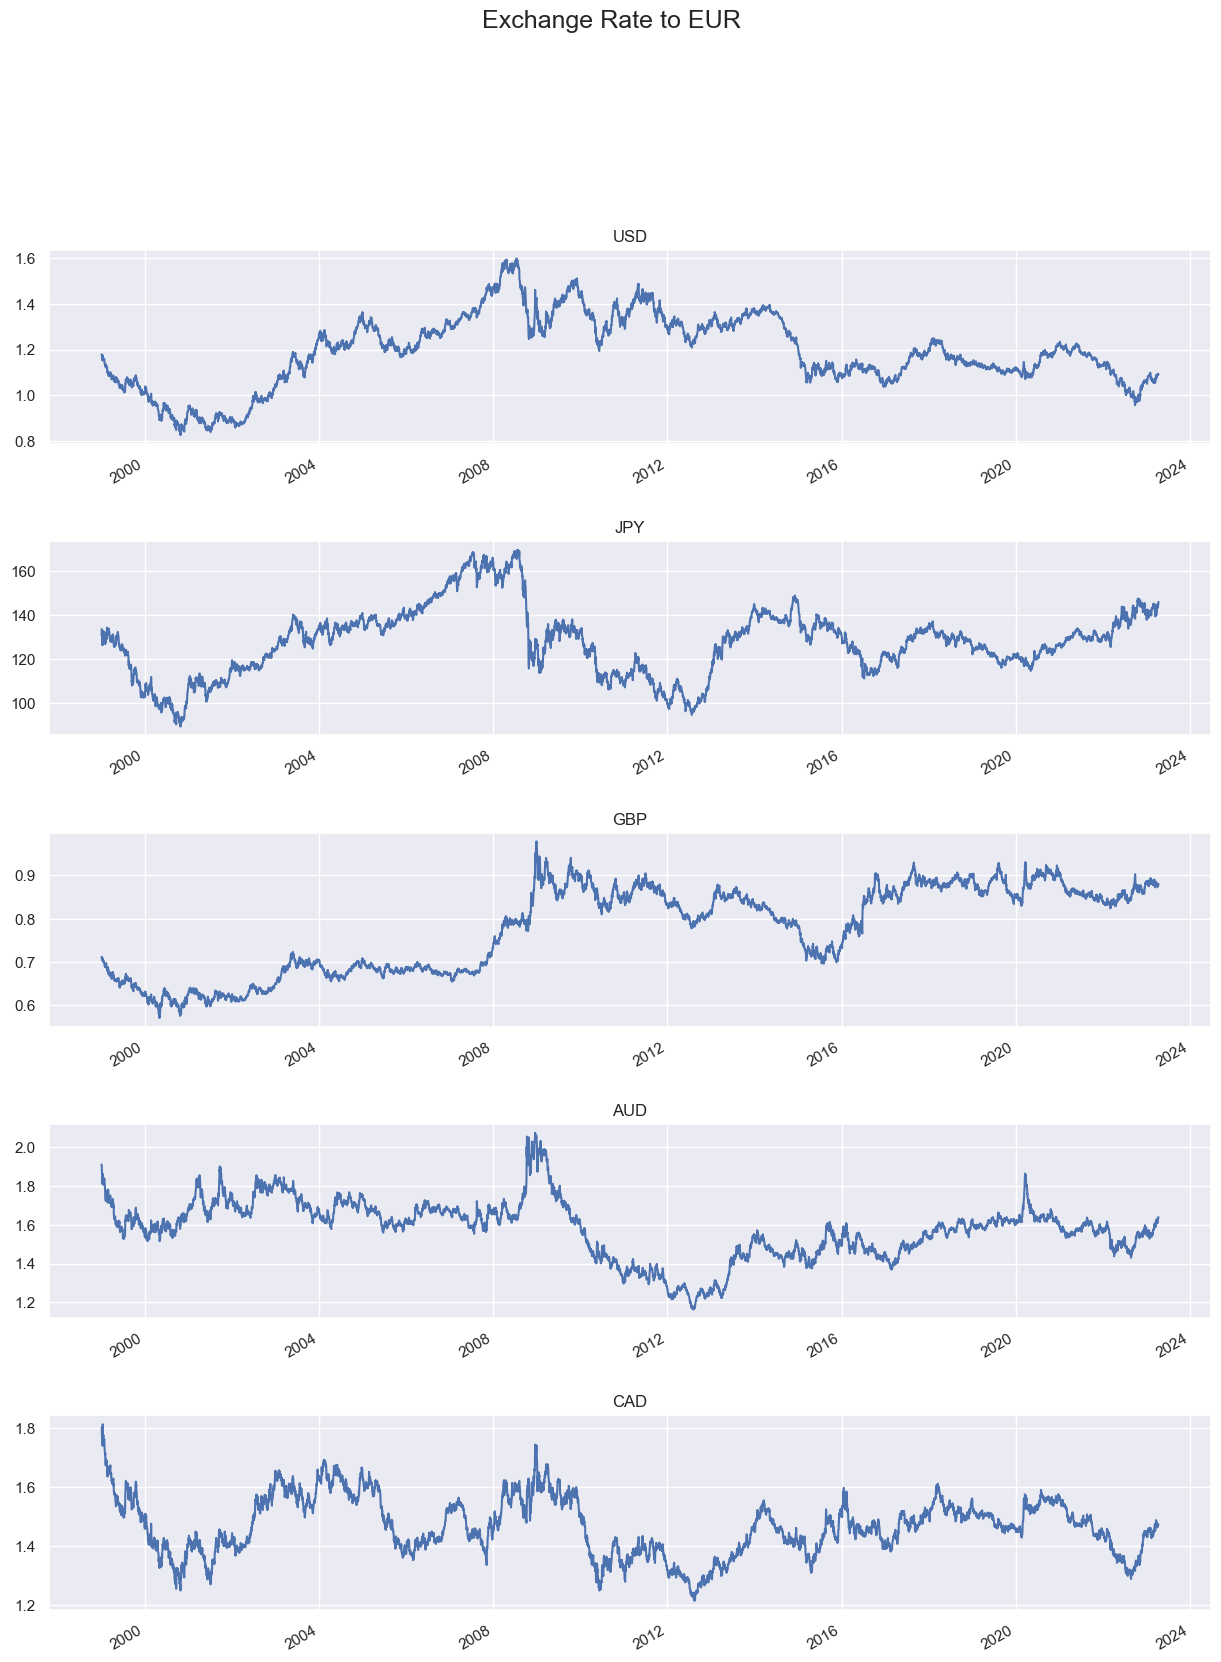

In [12]:
plt.figure(figsize=(15,20))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Exchange Rate to EUR', fontsize=18,y=1)

# loop through the length of currencies and keep track of index
for n, currency in enumerate(df5_list):
  # add new subplot iteratively
  ax = plt.subplot(5,1,n+1)
  df5.plot(x='Date',y=currency,ax=ax, legend=None)
  # chart formating
  ax.set_title(currency.upper())
  # ax.get_legend().remove()
  ax.set_xlabel("")
  # chart formating
  ax.set_title(currency.upper())
  # ax.get_legend().remove()
  ax.set_xlabel("")

Determine Stationarity
Is it a stationary series?

The mean of the time series should not be a finction of time. It should be constant.
The variance of the time series should not be a function of time.
The covariance of the ith term and the (i+m)th term should not be a function of time.
The statistical properties over time frame have to be constant and autocovariance must not fluctuate with time.

It seems JPY data high value pushed other data to the bottom, making it hard to analyze.
Let's separate JPY data from the orignal dataframe to distinguish it from the rest of the dataset.